<a href="https://colab.research.google.com/github/Milomem/Mental-Health/blob/main/Mental_Health.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install squarify
!pip install -U kaleido
!pip install scikit-learn==1.2.2
!pip install --upgrade category_encoders
!pip install pycaret
!pip install wandb

from pycaret.classification import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import squarify as sqa

from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split

!wget --no-check-certificate 'https://drive.google.com/uc?id=1C7qKYL1s89vGWHuWSR8DspN__UATqD-l' -O train.csv
!wget --no-check-certificate 'https://drive.google.com/uc?id=1KWifpt_M6rcFLJhY2PuWFsB84jxxw3X7' -O teste.csv

  Using cached scikit_learn-1.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.6 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.4.2
    Uninstalling scikit-learn-1.4.2:
      Successfully uninstalled scikit-learn-1.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pycaret 3.3.2 requires scikit-learn>1.4.0, but you have scikit-learn 1.2.2 which is incompatible.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.
  Using cached category_encoders-2.8.0-py3-none-any.whl.metadata (7.9 kB)
  Using cached scikit_learn-1.6.1-cp311-cp311-manylinux

In [2]:
import wandb
wandb.login()
config = {
    'model_type': 'lightgbm',  # Substitua pelo tipo de modelo desejado (ex: 'xgboost', 'rf', 'dt', etc.)
    'learning_rate': 0.1,
    'n_estimators': 100,
    'max_depth': 5,
    'num_leaves': 31,
    'min_child_samples': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'objective': 'binary',  # 'multiclass' se for classificação multiclasse
    'metric': 'Accuracy',  # Ou outra métrica relevante para seu problema
    'boosting_type': 'gbdt',
    'early_stopping_rounds': 10, # Número de rodadas sem melhoria para parar o treinamento
    'seed': 123  # Para reprodutibilidade
}
wandb.init(project="Mental-Health", config=config)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: milomemfellipe (milomemfellipe-ufrn). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [3]:
df = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/teste.csv')

In [4]:
df.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   Academic Pressure                      27897 non-null   float64
 8   Work Pressure                          112782 non-null  float64
 9   CGPA                                   27898 non-null   float64
 10  Study Satisfaction                     27897 non-null   

In [6]:
print(f"There are {df.shape[1]} columns and {df.shape[0]} rows in the train dataset.")

There are 20 columns and 140700 rows in the train dataset.


In [7]:
print("There are {} duplicates in the dataset.".format(df.duplicated().sum()))

There are 0 duplicates in the dataset.


In [8]:
print(df.isnull().sum())


id                                            0
Name                                          0
Gender                                        0
Age                                           0
City                                          0
Working Professional or Student               0
Profession                                36630
Academic Pressure                        112803
Work Pressure                             27918
CGPA                                     112802
Study Satisfaction                       112803
Job Satisfaction                          27910
Sleep Duration                                0
Dietary Habits                                4
Degree                                        2
Have you ever had suicidal thoughts ?         0
Work/Study Hours                              0
Financial Stress                              4
Family History of Mental Illness              0
Depression                                    0
dtype: int64


In [9]:
# Drop 'id' column in both datasets
df_train = df.drop(['id'], axis=1)

# Define the target column
target_column = 'Depression'

# Select categorical and numerical columns (initial)
categorical_columns = df_train.select_dtypes(include=['object']).columns
numerical_columns = df_train.select_dtypes(exclude=['object']).columns.drop(target_column)

# Print out column information
print("Target Column:", target_column)
print("\nCategorical Columns:", categorical_columns.tolist())
print("\nNumerical Columns:", numerical_columns.tolist())

Target Column: Depression

Categorical Columns: ['Name', 'Gender', 'City', 'Working Professional or Student', 'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']

Numerical Columns: ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'Financial Stress']


In [10]:
for column in categorical_columns:
    num_unique = df_train[column].nunique()
    print(f"'{column}' has {num_unique} unique categories.")

'Name' has 422 unique categories.
'Gender' has 2 unique categories.
'City' has 98 unique categories.
'Working Professional or Student' has 2 unique categories.
'Profession' has 64 unique categories.
'Sleep Duration' has 36 unique categories.
'Dietary Habits' has 23 unique categories.
'Degree' has 115 unique categories.
'Have you ever had suicidal thoughts ?' has 2 unique categories.
'Family History of Mental Illness' has 2 unique categories.


In [11]:
for column in categorical_columns:
    print(f"\nTop value counts in '{column}':\n{df_train[column].value_counts().head(10)}")


Top value counts in 'Name':
Name
Rohan          3178
Aarav          2336
Rupak          2176
Aaradhya       2045
Anvi           2035
Raghavendra    1877
Vani           1657
Tushar         1596
Ritvik         1589
Shiv           1568
Name: count, dtype: int64

Top value counts in 'Gender':
Gender
Male      77464
Female    63236
Name: count, dtype: int64

Top value counts in 'City':
City
Kalyan           6591
Patna            5924
Vasai-Virar      5765
Kolkata          5689
Ahmedabad        5613
Meerut           5528
Ludhiana         5226
Pune             5210
Rajkot           5207
Visakhapatnam    5176
Name: count, dtype: int64

Top value counts in 'Working Professional or Student':
Working Professional or Student
Working Professional    112799
Student                  27901
Name: count, dtype: int64

Top value counts in 'Profession':
Profession
Teacher             24906
Content Writer       7814
Architect            4370
Consultant           4229
HR Manager           4022
Pharmacist  

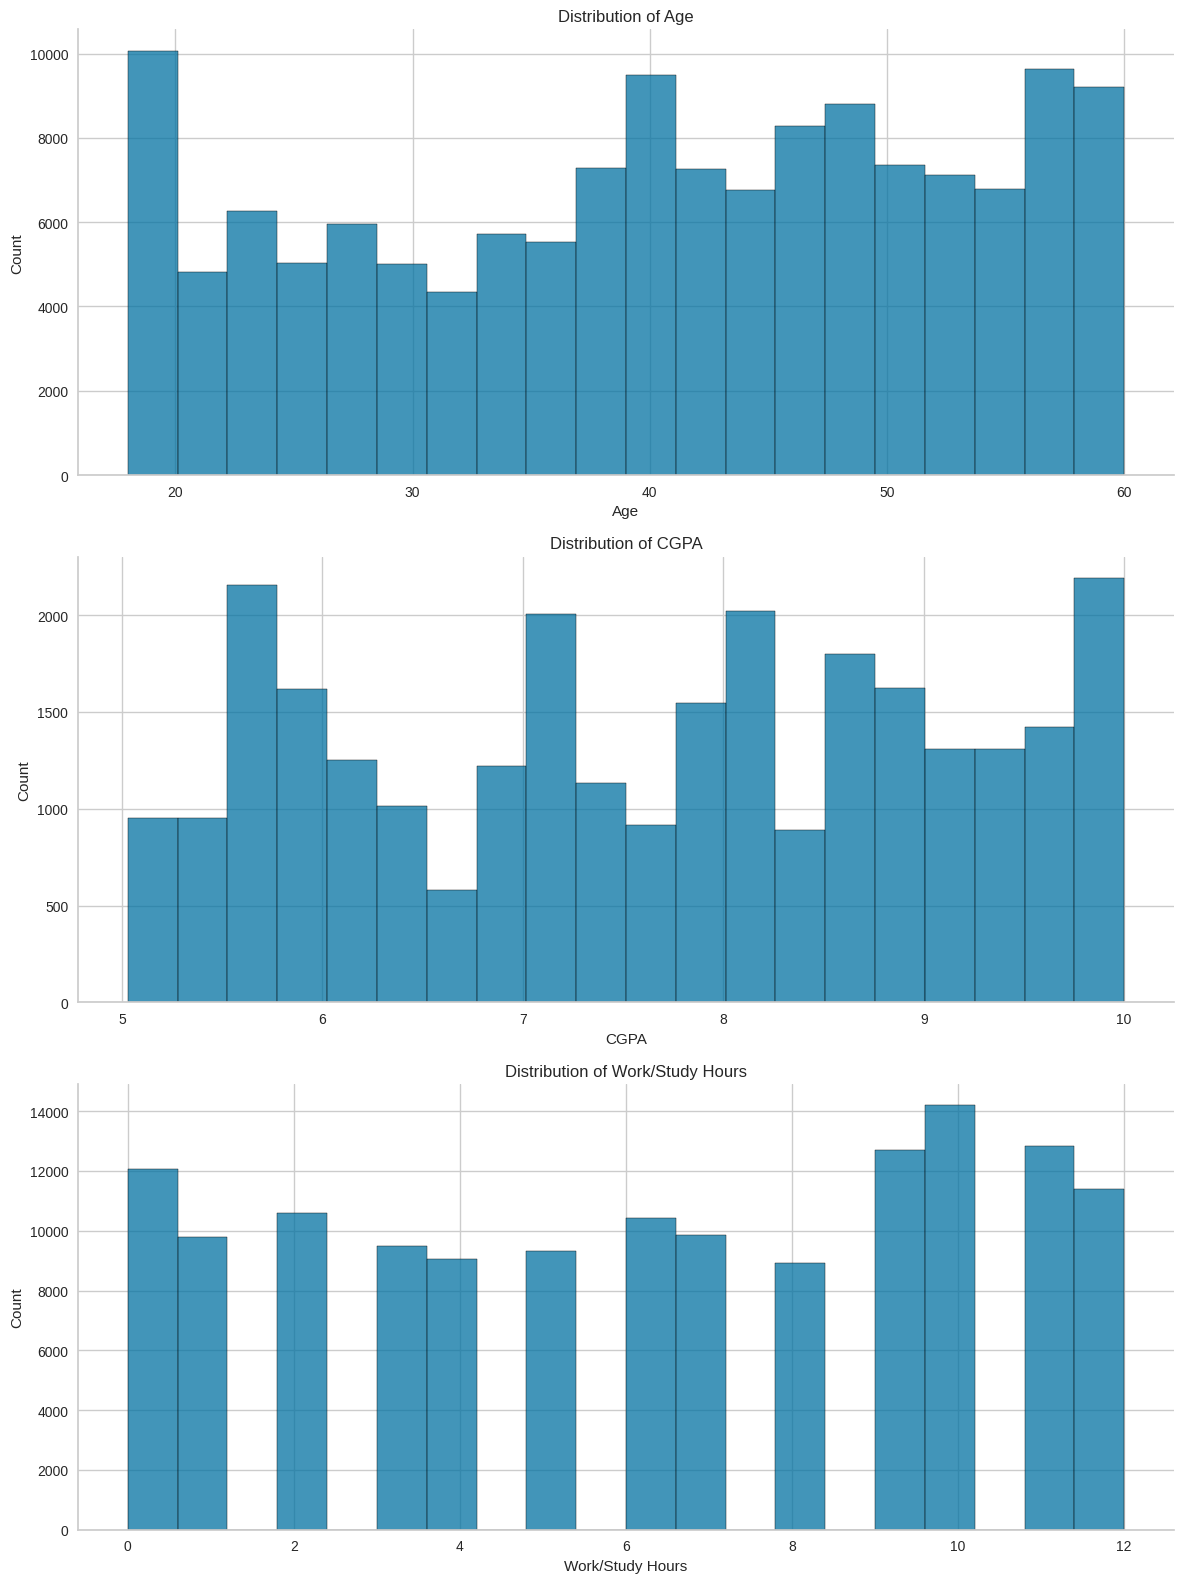

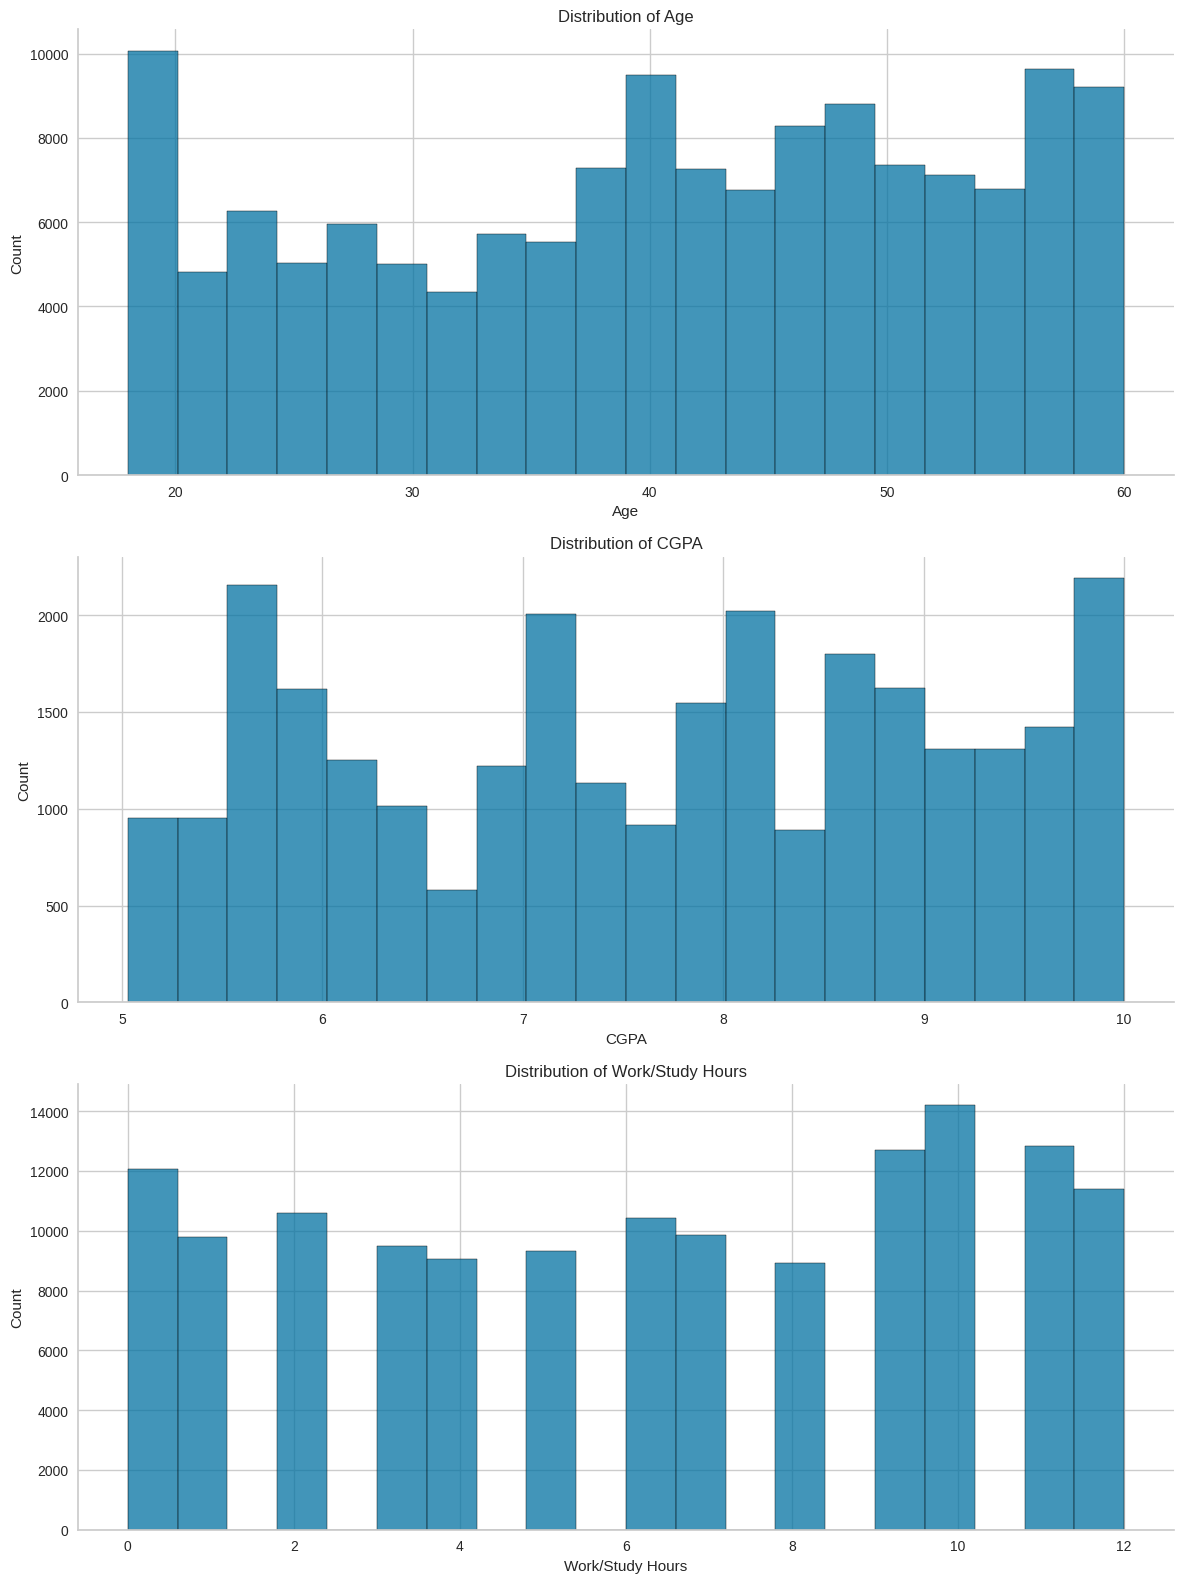

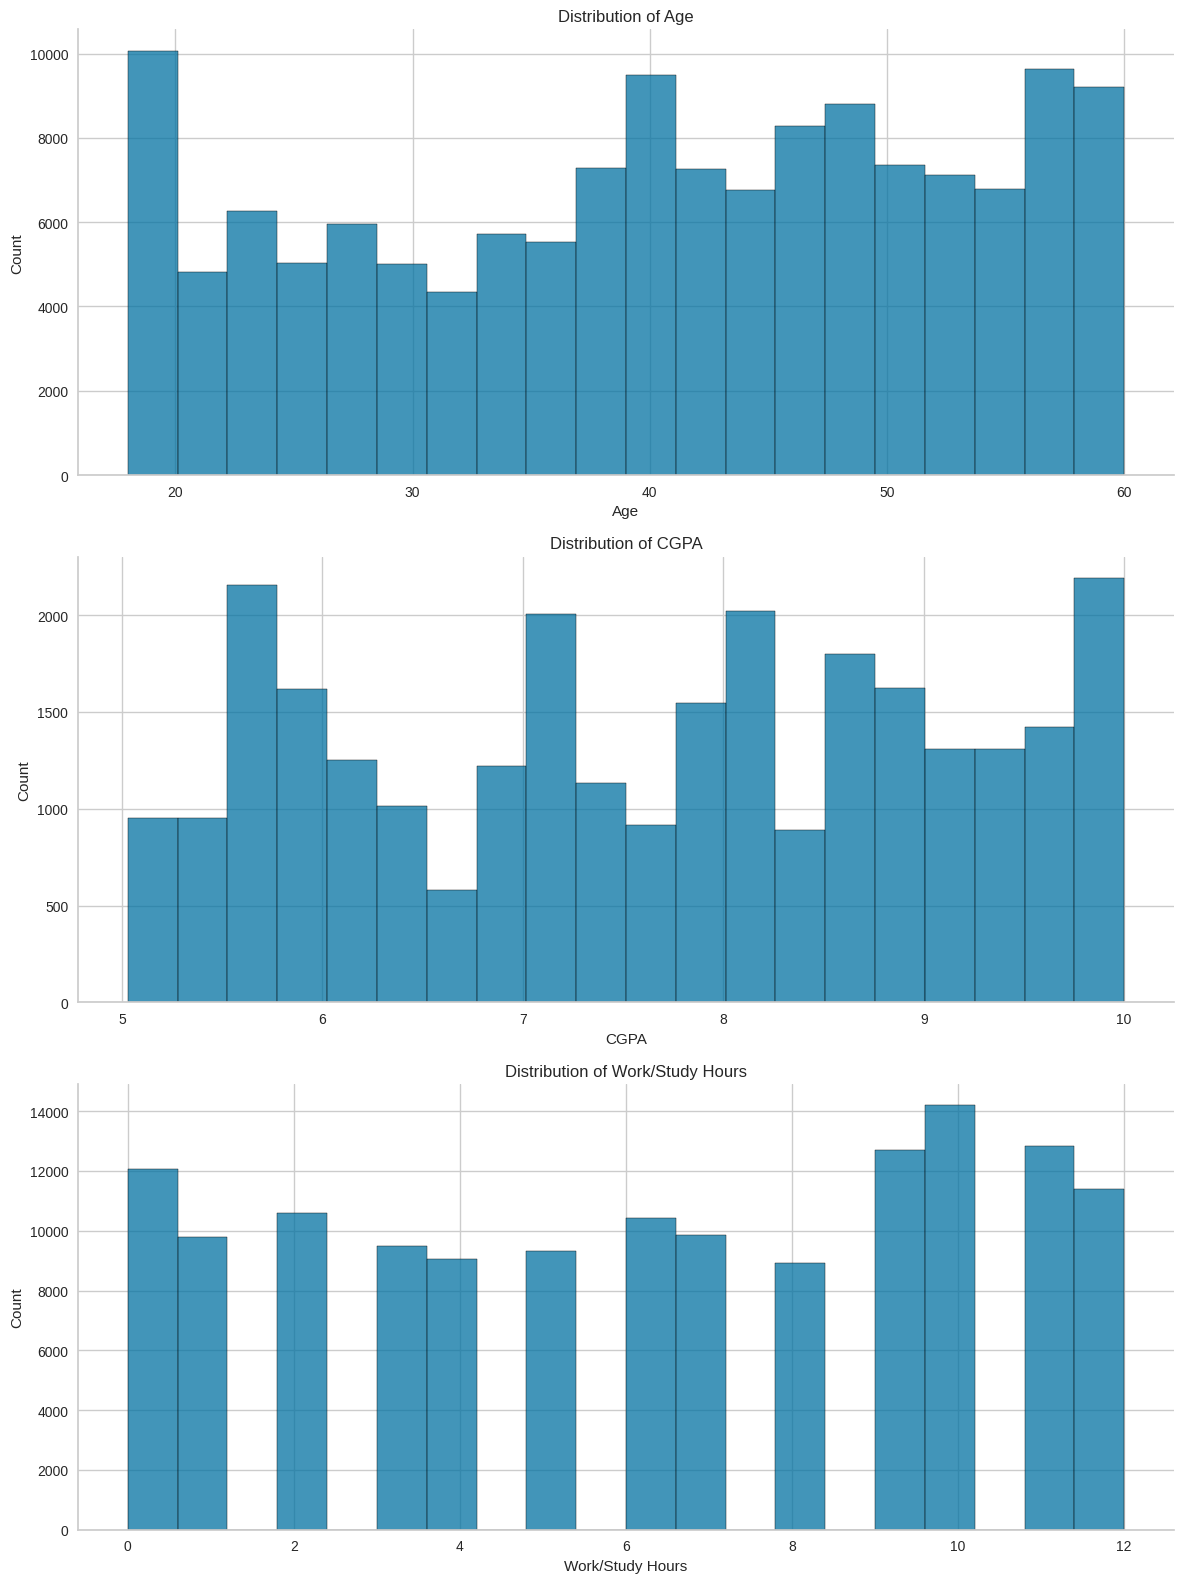

In [12]:
numerical_columns_to_plot = ["Age", "CGPA", "Work/Study Hours"]

for column in numerical_columns_to_plot:
    plt.figure(figsize=(12, 16))

    for i, column in enumerate(numerical_columns_to_plot):
        plt.subplot(3, 1, i+1)
        sns.histplot(data=df_train, x=column, kde=False, bins=20)
        plt.title(f'Distribution of {column}')
        sns.despine()

    # Replace forward slashes AND spaces with underscores in the filename and artifact name
    filename = f"dist_{column.replace('/', '_').replace(' ', '_')}.png"
    artifact_name = f'dist_{column.replace("/", "_").replace(" ", "_")}'
    plt.savefig(filename)
    wandb.log_artifact(filename, name=artifact_name, type='visualization')

    plt.tight_layout()
    plt.show()

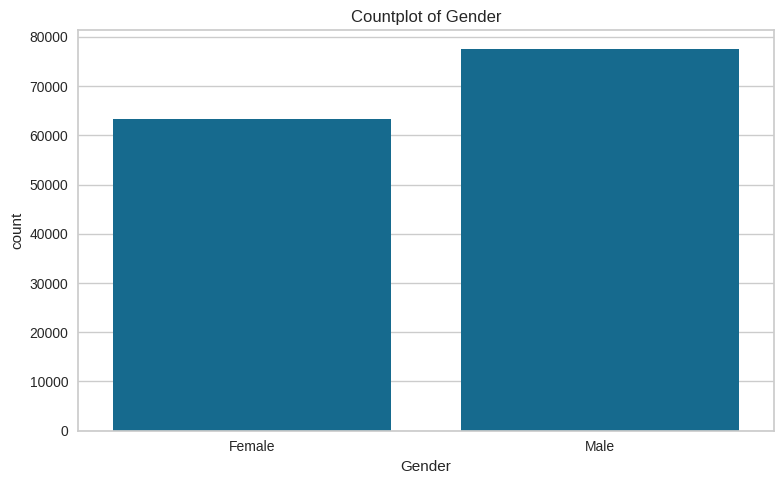

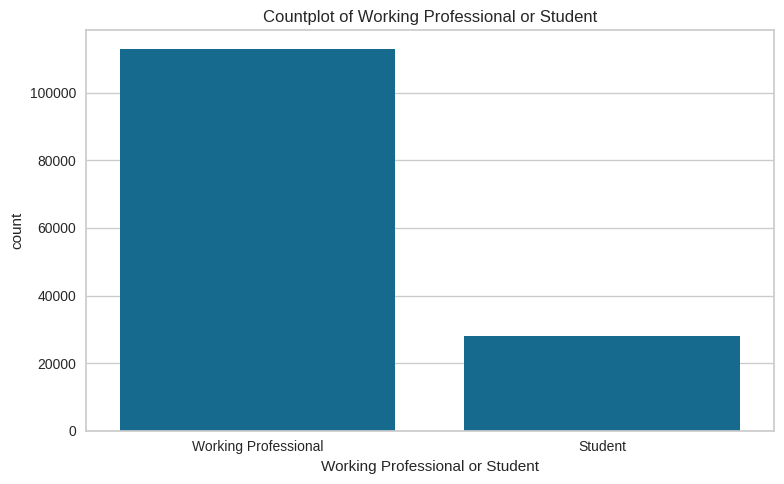

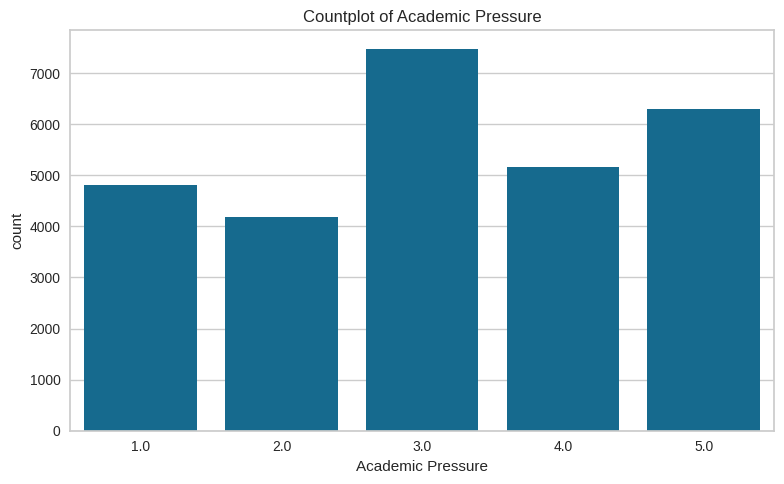

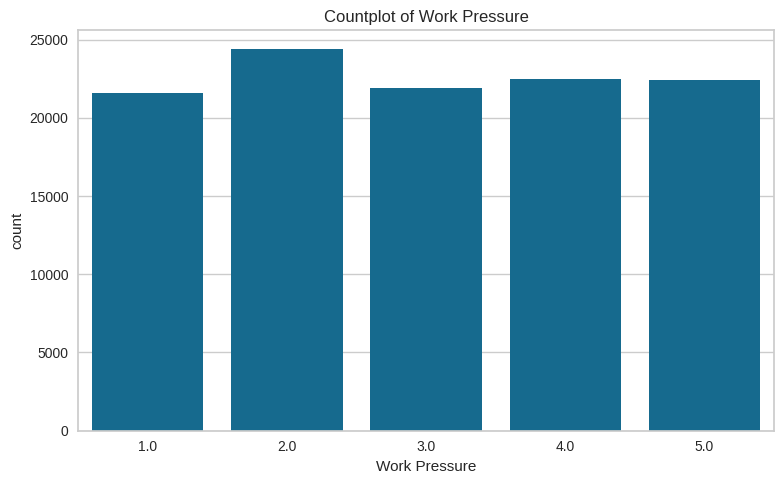

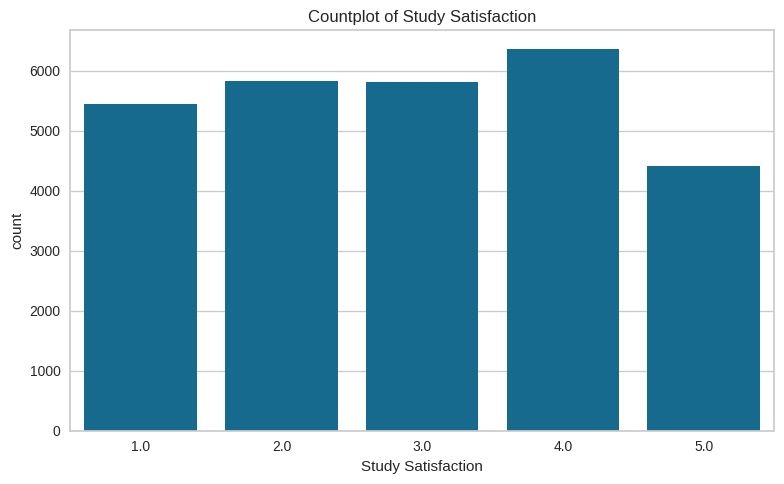

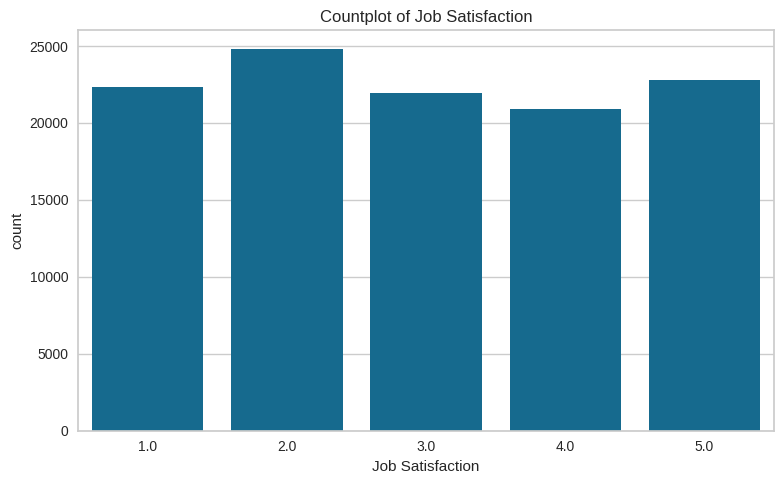

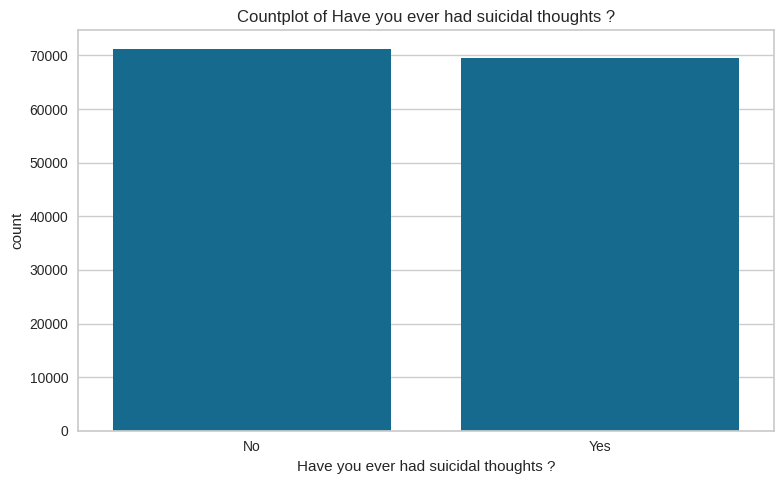

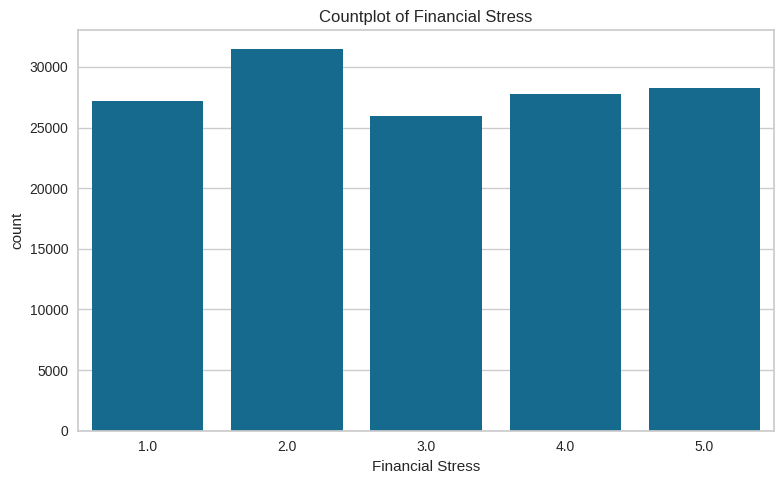

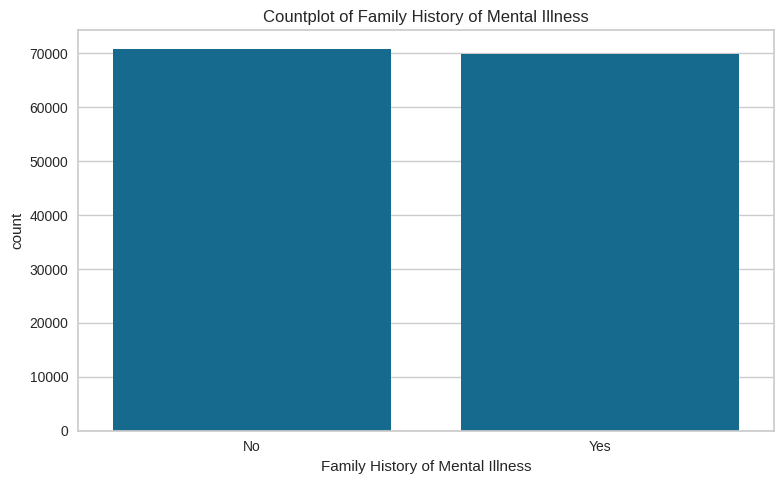

In [13]:
categorical_columns_to_plot = ['Gender', 'Working Professional or Student', 'Academic Pressure',
                       'Work Pressure', 'Study Satisfaction', 'Job Satisfaction',
                       'Have you ever had suicidal thoughts ?', 'Financial Stress',
                       'Family History of Mental Illness']

# Plot countplots for each categorical column
for column in categorical_columns_to_plot:

    plt.figure(figsize=(8, 5))
    sns.countplot(data=df_train, x=column)
    plt.title(f'Countplot of {column}')

    plt.tight_layout()
    plt.show()


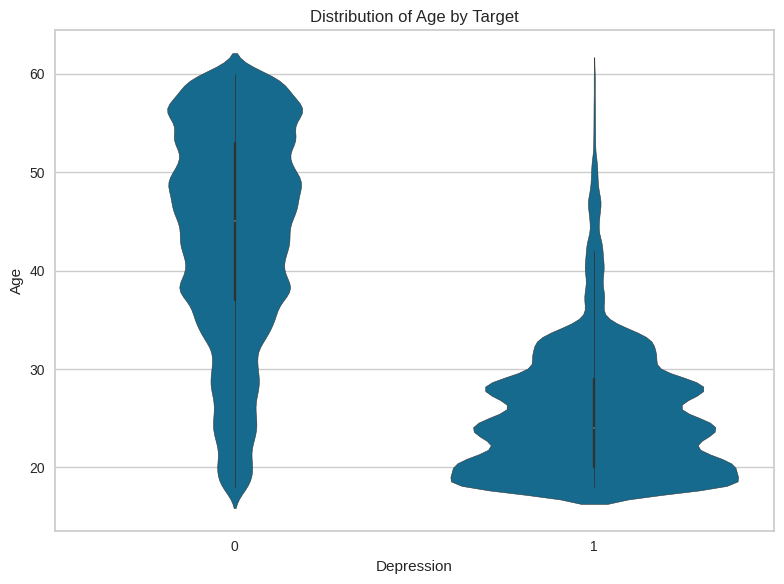

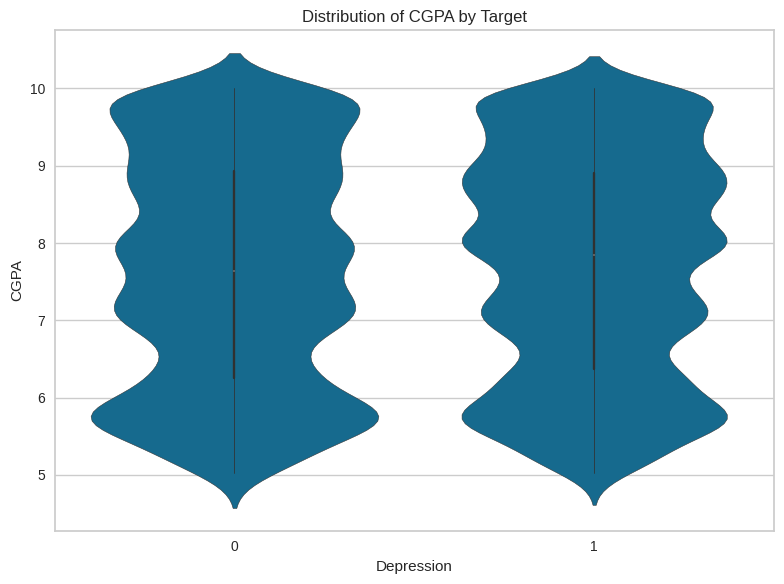

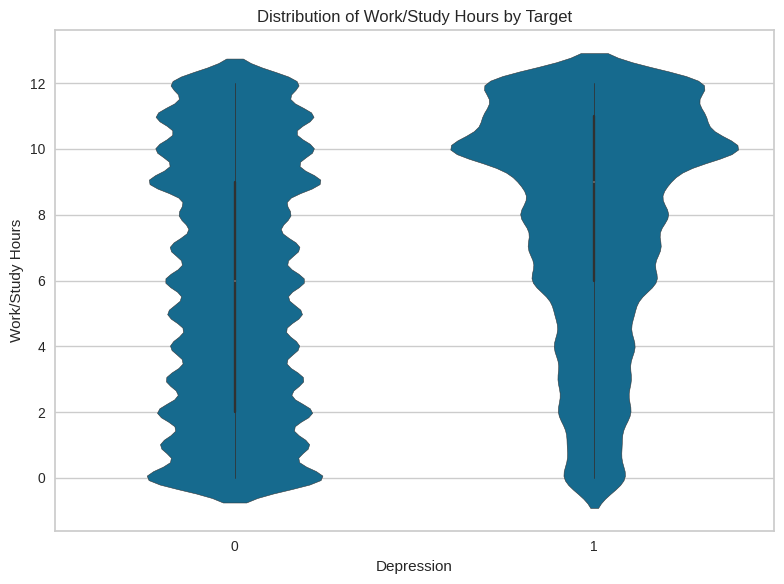

In [14]:
for column in numerical_columns_to_plot:
    plt.figure(figsize=(8, 6))
    sns.violinplot(data=df_train, x=target_column, y=column)
    plt.title(f'Distribution of {column} by Target')

    plt.tight_layout()
    plt.show()

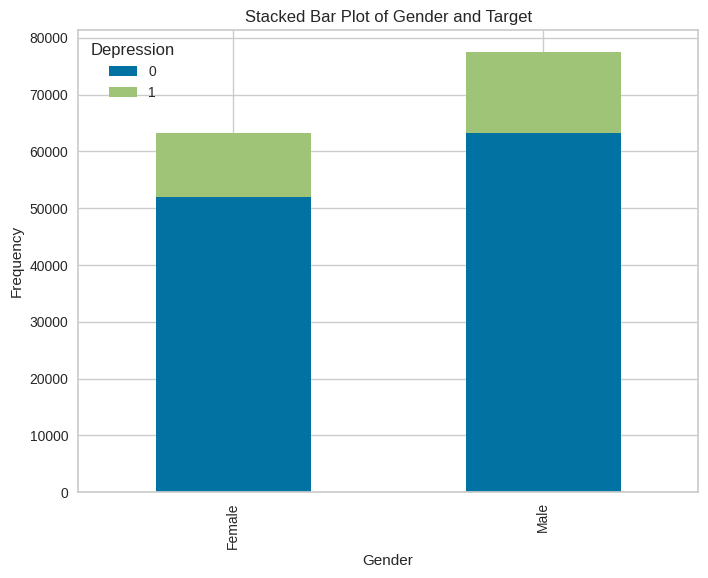

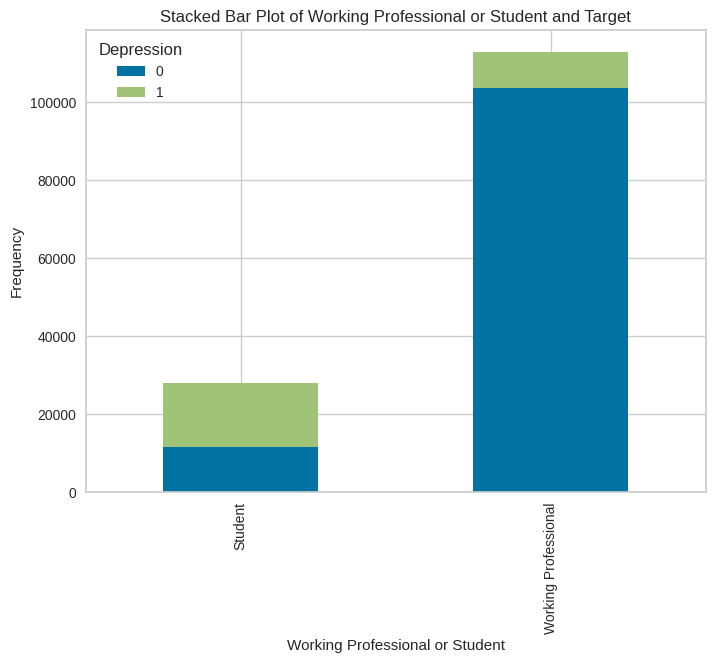

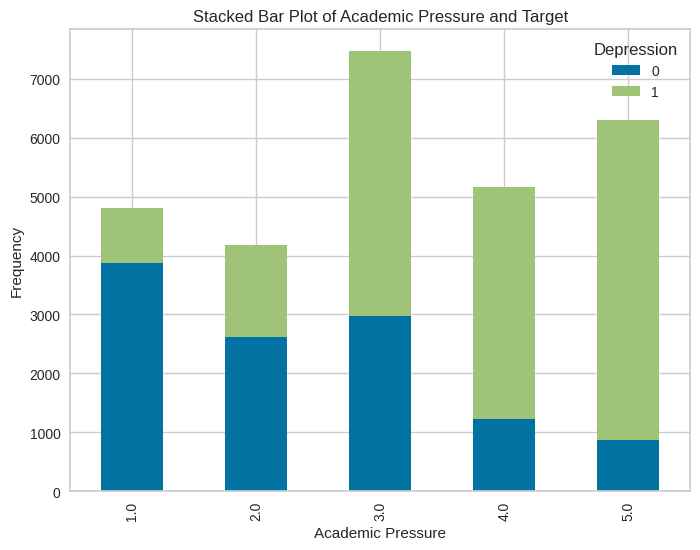

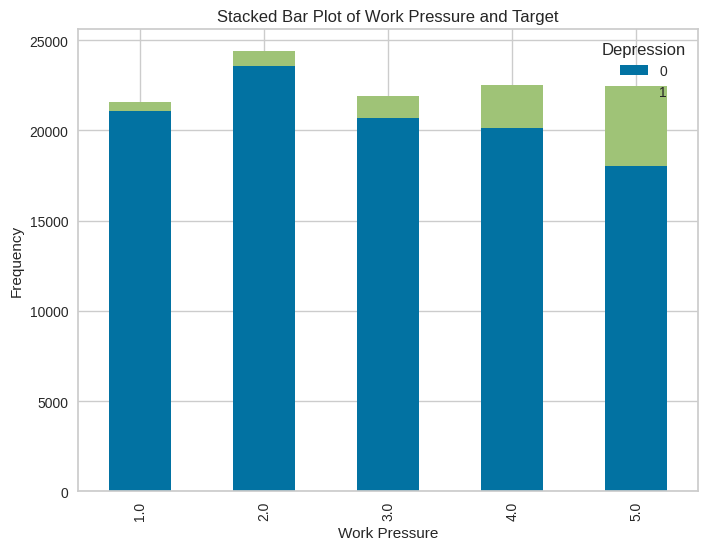

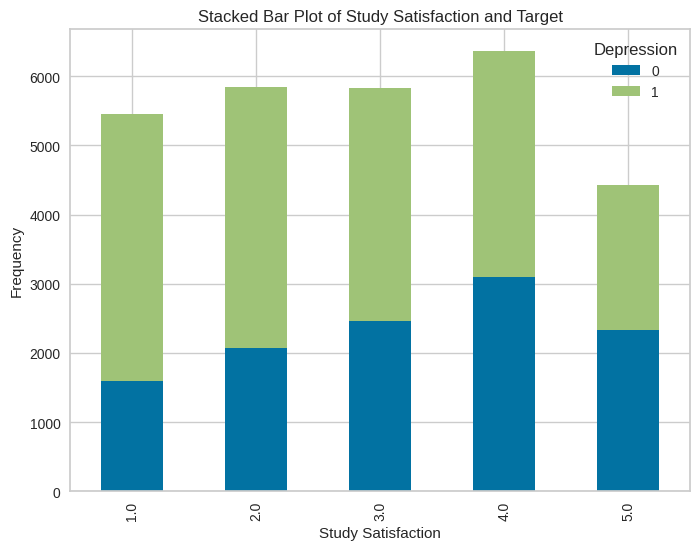

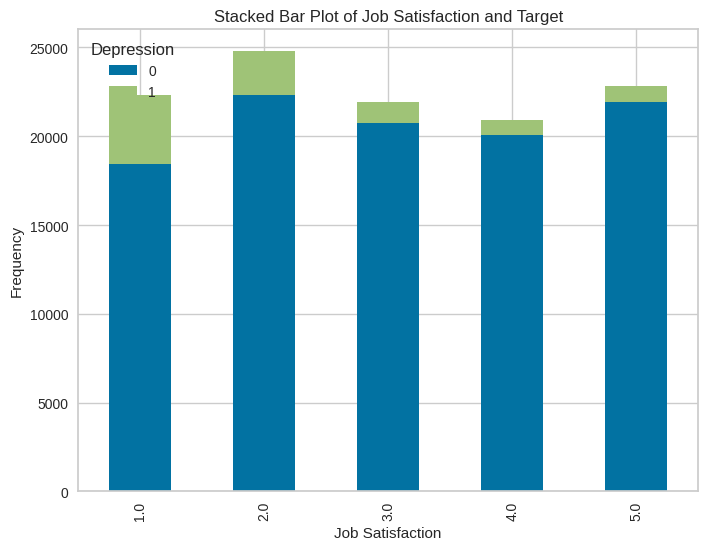

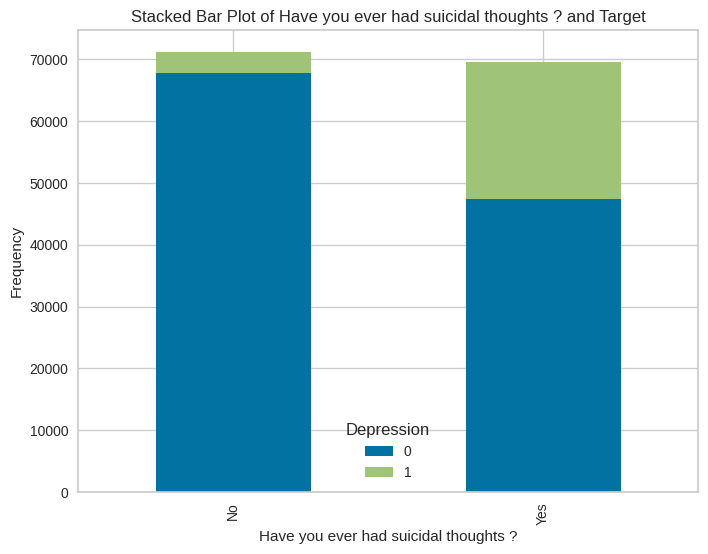

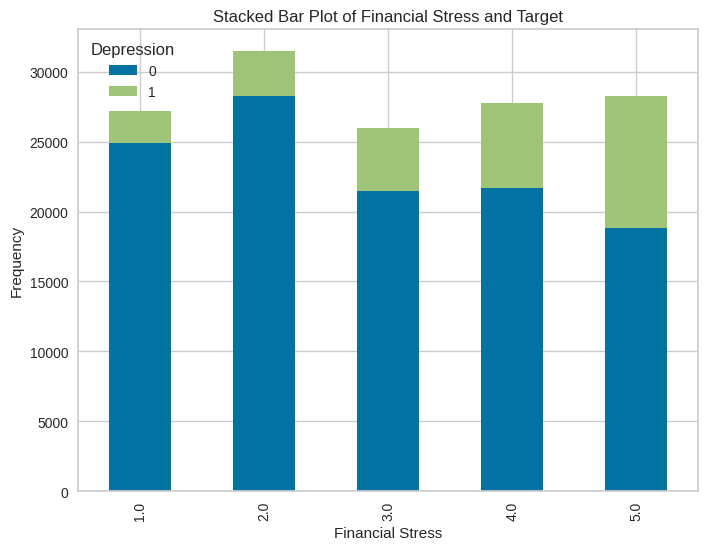

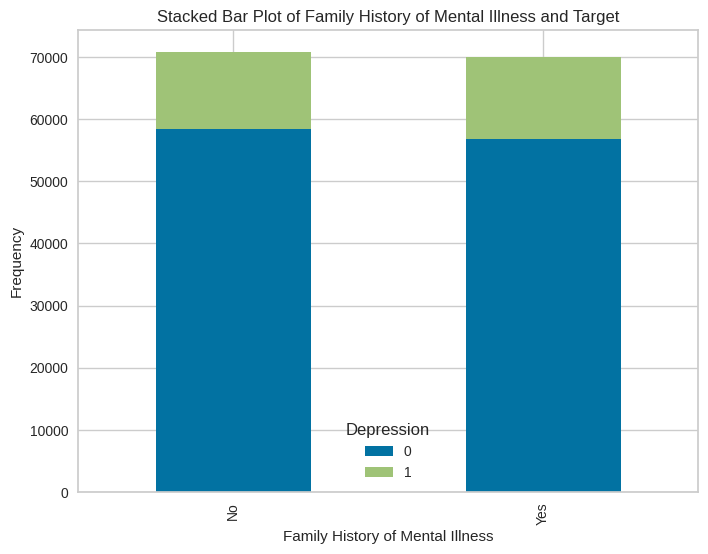

In [15]:
# Loop through each categorical column in your list
for column in categorical_columns_to_plot:
    # Stacked Bar Plot
    pd.crosstab(df_train[column], df_train[target_column]).plot(kind='bar', stacked=True, figsize=(8, 6))
    plt.title(f"Stacked Bar Plot of {column} and Target")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()

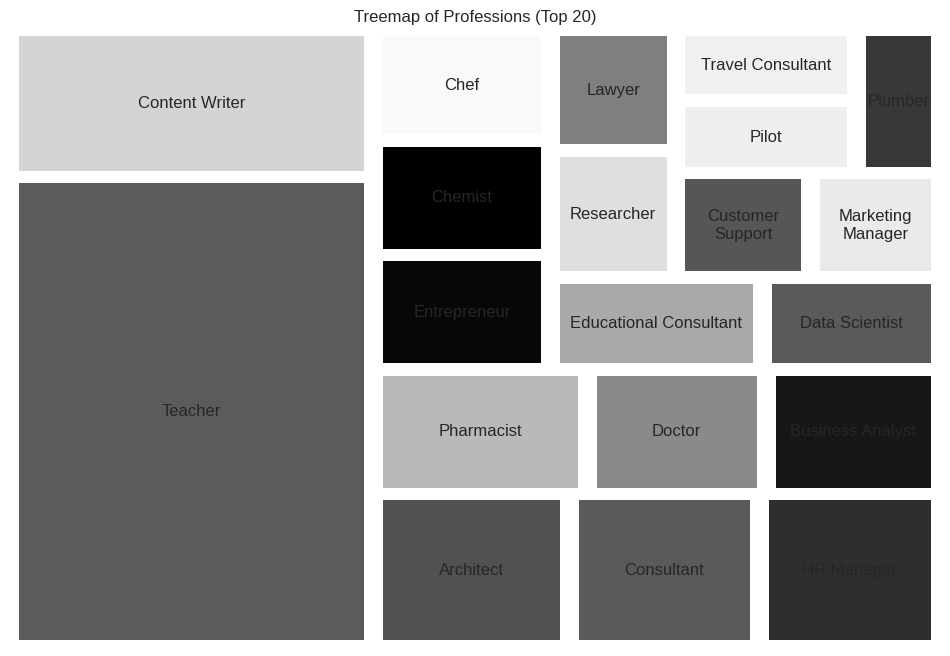

In [16]:
# Calculate frequencies
value_counts = df_train['Profession'].value_counts()
sizes = value_counts.values[:20]  # Show only the top 20 for readability

# Modify specific labels to show on two lines and limit to top 20 labels
labels = [
    "Customer\nSupport" if label == "Customer Support" else
    "Marketing\nManager" if label == "Marketing Manager" else
    label
    for label in value_counts.index[:20]
]

plt.figure(figsize=(12, 8))
sqa.plot(sizes=sizes, label=labels, pad=True)
plt.title(f"Treemap of Professions (Top 20)")
plt.axis("off")
plt.show()

In [17]:
# Create a DataFrame for the top 20 professions and their relationship with depression
top_n_professions = 20
profession_counts = df_train['Profession'].value_counts().nlargest(top_n_professions)
filtered_data = df_train[df_train['Profession'].isin(profession_counts.index)]

# Create a summary DataFrame
sankey_data = filtered_data.groupby(['Profession', 'Depression']).size().reset_index(name='Count')

# Define the source and target for the Sankey chart
labels = list(sankey_data['Profession'].unique()) + ['No Depression', 'Depression']
source_indices = []
target_indices = []

for _, row in sankey_data.iterrows():
    profession_index = labels.index(row['Profession'])
    depression_index = labels.index('Depression' if row['Depression'] == 1 else 'No Depression')
    source_indices.append(profession_index)
    target_indices.append(depression_index)

# Create a Sankey chart
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color='blue'
    ),
    link=dict(
        source=source_indices,  # Indices correspond to labels, e.g., A=0, B=1, C=2...
        target=target_indices,
        value=sankey_data['Count']
    )
)])

fig.update_layout(
    title_text="Sankey Diagram of Profession and Depression",
    font_size=10,
    width=700,
    height=600)

fig.show()

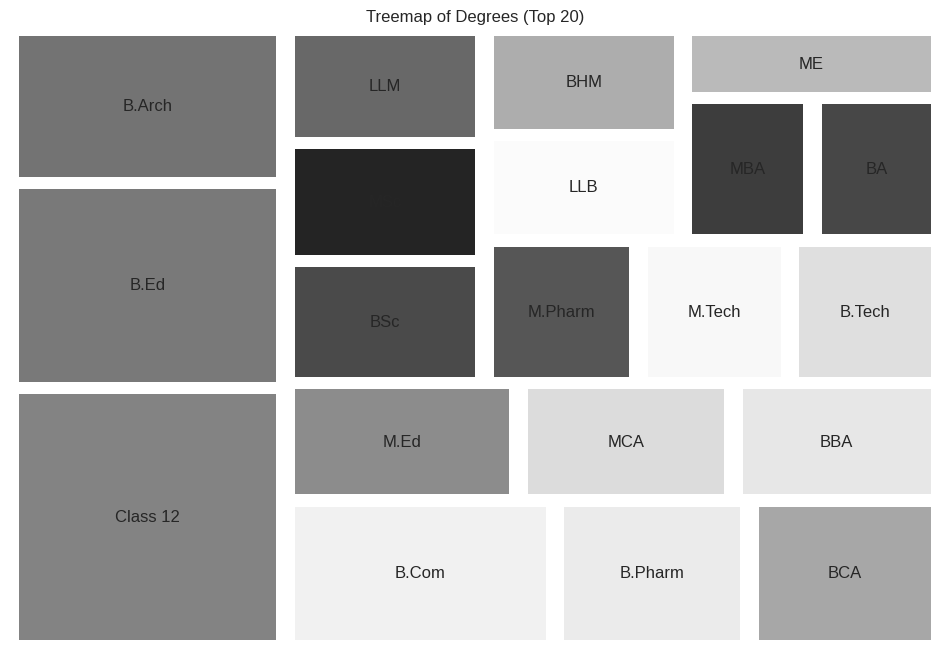

In [18]:
# Calculate frequencies
value_counts = df_train['Degree'].value_counts()
sizes = value_counts.values[:20]  # Show only the top 20 for readability

plt.figure(figsize=(12, 8))
sqa.plot(sizes=sizes, label=value_counts.index[:20], pad=True)
plt.title(f"Treemap of Degrees (Top 20)")
plt.axis("off")
plt.show()

In [19]:
# Get the top 10 most common professions
top_professions = df_train['Degree'].value_counts().nlargest(10).index

# Filter the DataFrame for the top 10 professions
filtered_df = df_train[df_train['Degree'].isin(top_professions)]

# Create a new DataFrame for aggregation
agg_data = filtered_df.groupby(['Degree', 'Depression']).size().reset_index(name='Count')

# Create a sunburst chart
fig = px.sunburst(agg_data,
                  path=['Degree', 'Depression'],
                  values='Count',
                  title='Sunburst Chart of Top 10 Degrees and Depression',
                  color='Count',
                  color_continuous_scale=px.colors.sequential.Oranges[:])

# Show the figure
fig.show()

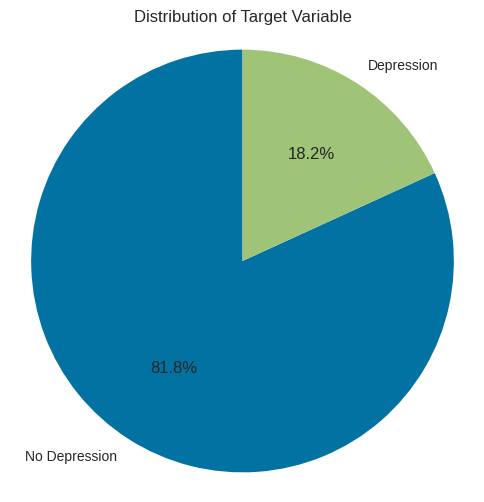

In [20]:
# Calculate counts for the pie chart and add labels
class_counts = df_train[target_column].value_counts().sort_index()
labels = ["No Depression", "Depression"]
plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=labels,
        autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Target Variable')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [21]:
# Calculate the correlation matrix
correlation_matrix = df_train.corr(numeric_only=True)

# Create an interactive heatmap with orange and blue colors
fig = px.imshow(correlation_matrix,
                text_auto=True,  # Display correlation values
                color_continuous_scale='RdYlBu',  # Color scale with shades of red, yellow, and blue
                title='Heatmap of Correlation Matrix',
                aspect='auto')

# Show the plot
fig.show()

In [22]:
# Drop rows with NaN values in 'Age', 'Work Pressure', and 'Depression' columns
df_train_copy = df_train.dropna(subset=['Age', 'Work Pressure', 'Depression'])

# Create bins for Age and Work Pressure
df_train_copy['Age_bin'] = pd.cut(df_train_copy['Age'], bins=10).astype(str)           # Convert the bins to strings (to avoid serialization issues)
df_train_copy['WorkPressure_bin'] = pd.cut(df_train_copy['Work Pressure'], bins=10).astype(str)

# Create pivot table
heatmap_data = df_train_copy.pivot_table(index='Age_bin', columns='WorkPressure_bin', values='Depression', aggfunc='mean')

# Create an interactive heatmap with orange and blue colors
fig = px.imshow(heatmap_data.values,  # Use only the numerical matrix
                labels=dict(x="Work Pressure Bin", y="Age Bin", color="Depression"),
                text_auto=True,  # Display correlation values
                color_continuous_scale='RdYlBu',  # Color scale with shades of red, yellow, and blue
                title='Heatmap of Depression by Age and Work Pressure',
                aspect='auto')

# Set the y-axis and x-axis tick labels to the actual bin ranges
fig.update_layout(
    yaxis=dict(
        tickmode='array',
        tickvals=list(range(len(heatmap_data.index))),  # Set tick positions
        ticktext=heatmap_data.index.astype(str).tolist()  # Convert intervals to strings for labels
    ),
    xaxis=dict(
        tickmode='array',
        tickvals=list(range(len(heatmap_data.columns))),  # Set tick positions
        ticktext=heatmap_data.columns.astype(str).tolist()  # Convert intervals to strings for labels
    )
)

# Show the plot
fig.show()

In [23]:
# Feature Engineering
# Create an interaction term between Age and Work Pressure
df['Age_WorkPressure'] = df['Age'] * df['Work Pressure']
df_test['Age_WorkPressure'] = df_test['Age'] * df_test['Work Pressure']

# Target encoding for categorical features
encoder = TargetEncoder(cols=['City', 'Profession'])
df_train[['City_encoded', 'Profession_encoded']] = encoder.fit_transform(df_train[['City', 'Profession']], df_train["Depression"])
df_test[['City_encoded', 'Profession_encoded']] = encoder.transform(df_test[['City', 'Profession']])

# Dividir df_test em holdout e teste final
df_holdout, df_test_final = train_test_split(df_test, test_size=0.6, random_state=123)

In [24]:
# Define features and target
X_train = df_train.drop('Depression', axis=1)
y_train = df_train['Depression']

# Redefine columns for preprocessing after feature engineering
numerical_columns = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_columns = X_train.select_dtypes(include=['object']).columns.tolist()

# Initialize setup
clf = setup(data=df_train, target=target_column, session_id=123)

# Compare different models
best_model = compare_models()

metrics = pull()  # Obtém as métricas do PyCaret

# Convert the Pandas DataFrame to a dictionary before logging
metrics_dict = metrics.to_dict(orient='records')  # or 'list', depending on your desired format
# Flatten the metrics dictionary if it's nested
metrics_dict = {k: v for d in metrics_dict for k, v in d.items()}

wandb.log(metrics_dict) # Log the dictionary

# Make predictions on the test set
predictions = predict_model(best_model, data=df_test_final)

predictions.to_csv('previsoes.csv', index=False)
wandb.log_artifact('previsoes.csv', name='previsoes', type='predictions')

,Description,Value
0,Session id,123
1,Target,Depression
2,Target type,Binary
3,Original data shape,"(140700, 21)"
4,Transformed data shape,"(140700, 39)"
5,Transformed train set shape,"(98490, 39)"
6,Transformed test set shape,"(42210, 39)"
7,Numeric features,10
8,Categorical features,10
9,Rows with missing values,100.0%


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9390,0.9744,0.8181,0.8419,0.8298,0.7926,0.7928,6.1170
lr,Logistic Regression,0.9382,0.9737,0.8072,0.8456,0.8259,0.7883,0.7887,6.5230
ada,Ada Boost Classifier,0.9375,0.9733,0.8109,0.8400,0.8251,0.7871,0.7873,5.2520
gbc,Gradient Boosting Classifier,0.9374,0.9736,0.8032,0.8447,0.8234,0.7853,0.7857,17.8000
xgboost,Extreme Gradient Boosting,0.9370,0.9730,0.8137,0.8353,0.8243,0.7859,0.7860,2.7980
rf,Random Forest Classifier,0.9363,0.9708,0.7902,0.8490,0.8185,0.7800,0.7808,13.4730
et,Extra Trees Classifier,0.9341,0.9702,0.7780,0.8468,0.8109,0.7711,0.7721,13.8640
svm,SVM - Linear Kernel,0.9259,0.9726,0.8160,0.8053,0.7982,0.7537,0.7621,3.0140
lda,Linear Discriminant Analysis,0.9255,0.9670,0.7654,0.8136,0.7887,0.7435,0.7441,1.4660
knn,K Neighbors Classifier,0.9227,0.9388,0.7790,0.7921,0.7855,0.7383,0.7384,14.5460


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

<Artifact previsoes>

In [27]:
# Concatenar os dados de treinamento e holdout
df_retrain = pd.concat([df_train, df_holdout], ignore_index=True)

# Certifique-se que 'Depression' está presente em df_holdout e preencha com 0 se necessário
# Verifique se a coluna 'Depression' existe antes de tentar atribuir valores
if 'Depression' not in df_holdout.columns:
    df_holdout['Depression'] = 0  # Assuming 0 represents 'No Depression' in your case
elif df_holdout['Depression'].isnull().any():
    # Preencha os valores ausentes com 0 se a coluna existir, mas tiver valores ausentes
    df_holdout['Depression'] = df_holdout['Depression'].fillna(0)

# --- The fix starts here ---
# Ensure 'Depression' column is of numeric type
df_retrain['Depression'] = pd.to_numeric(df_retrain['Depression'])

# Drop rows with NaN values in the target column 'Depression'
df_retrain = df_retrain.dropna(subset=['Depression'])
# --- The fix ends here ---

# Redefinir X e y para o novo conjunto de dados
X_retrain = df_retrain.drop('Depression', axis=1)
y_retrain = df_retrain['Depression']

# Reinitialize setup with the concatenated data
clf = setup(data=df_retrain, target=target_column, session_id=123)

# Retreinar o modelo do zero com os dados combinados
retrained_model = create_model(best_model)

# Avaliar o modelo
evaluate_model(retrained_model)

# Fazer previsões no conjunto de teste final
final_predictions = predict_model(retrained_model, data=df_test_final)

,Description,Value
0,Session id,123
1,Target,Depression
2,Target type,Binary
3,Original data shape,"(178220, 23)"
4,Transformed data shape,"(178220, 42)"
5,Transformed train set shape,"(124753, 42)"
6,Transformed test set shape,"(53467, 42)"
7,Numeric features,12
8,Categorical features,10
9,Rows with missing values,100.0%


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9524,0.9799,0.8268,0.8390,0.8329,0.8051,0.8051
1,0.9513,0.9817,0.8128,0.8420,0.8272,0.7988,0.7990
2,0.9548,0.9826,0.8358,0.8471,0.8414,0.8150,0.8151
3,0.9521,0.9809,0.8211,0.8409,0.8309,0.8030,0.8030
4,0.9536,0.9810,0.8195,0.8513,0.8351,0.8081,0.8083
5,0.9533,0.9809,0.8234,0.8470,0.8350,0.8079,0.8080
6,0.9524,0.9808,0.8196,0.8441,0.8316,0.8039,0.8040
7,0.9518,0.9810,0.8173,0.8423,0.8296,0.8016,0.8017
8,0.9489,0.9811,0.8095,0.8299,0.8196,0.7898,0.7899


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [28]:
save_model(retrained_model, 'tuned_best_model')
wandb.log_artifact('tuned_best_model.pkl', name='tuned_best_model', type='model')
wandb.finish()

Transformation Pipeline and Model Successfully Saved


AUC,▁
Accuracy,▁
F1,▁
Kappa,▁
MCC,▁
Prec.,▁
Recall,▁
TT (Sec),▁
AUC,0.7998
Accuracy,0.2839
F1,0.3414


In [ ]:
!pip install gradio
import gradio as gr

# Função para fazer previsões
def predict(Name, Gender, Age, City, Working_Professional_or_Student, Profession, Academic_Pressure, Work_Pressure, CGPA, Study_Satisfaction, Job_Satisfaction, Sleep_Duration, Dietary_Habits, Degree, Suicidal_Thoughts, Work_Study_Hours, Financial_Stress, Family_History_of_Mental_Illness, City_encoded, Profession_encoded):
    input_data = {
        'Name': [Name],
        'Gender': [Gender],
        'Age': [Age],
        'City': [City],
        'Working Professional or Student': [Working_Professional_or_Student],
        'Profession': [Profession],
        'Academic Pressure': [Academic_Pressure],
        'Work Pressure': [Work_Pressure],
        'CGPA': [CGPA],
        'Study Satisfaction': [Study_Satisfaction],
        'Job Satisfaction': [Job_Satisfaction],
        'Sleep Duration': [Sleep_Duration],
        'Dietary Habits': [Dietary_Habits],
        'Degree': [Degree],
        'Have you ever had suicidal thoughts ?': [Suicidal_Thoughts],
        'Work/Study Hours': [Work_Study_Hours],
        'Financial Stress': [Financial_Stress],
        'Family History of Mental Illness': [Family_History_of_Mental_Illness],
        'City_encoded': [City_encoded],
        'Profession_encoded': [Profession_encoded]
    }
    input_df = pd.DataFrame(input_data)
    prediction = predict_model(best_model, data=input_df)
    return prediction['Label'][0]

# Cria a interface Gradio
interface = gr.Interface(
    fn=predict,
    inputs=[
        gr.Textbox(label="Name"),
        gr.Dropdown(['Male', 'Female', 'Other'], label="Gender"),
        gr.Number(label="Age"),
        gr.Textbox(label="City"),
        gr.Dropdown(['Working Professional', 'Student'], label="Working Professional or Student"),
        gr.Textbox(label="Profession"),
        gr.Number(label="Academic Pressure"),
        gr.Number(label="Work Pressure"),
        gr.Number(label="CGPA"),
        gr.Number(label="Study Satisfaction"),
        gr.Number(label="Job Satisfaction"),
        gr.Textbox(label="Sleep Duration"),
        gr.Textbox(label="Dietary Habits"),
        gr.Textbox(label="Degree"),
        gr.Dropdown(['Yes', 'No'], label="Have you ever had suicidal thoughts ?"),
        gr.Number(label="Work/Study Hours"),
        gr.Number(label="Financial Stress"),
        gr.Dropdown(['Yes', 'No'], label="Family History of Mental Illness"),
        gr.Number(label="City_encoded"),
        gr.Number(label="Profession_encoded")
    ],
    outputs=gr.Textbox(label="Prediction")
)

# Executa a interface
interface.launch()